In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', 1_000)
pd.set_option('display.float_format', lambda x: '%.2f' %x)
pd.set_option('display.width', 500)

In [2]:
df = pd.read_excel('amazon.xlsx')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [3]:
df.sample(5)

,Star,HelpFul,Title,Review
5064,2,0,It's ok Don't feel it was worth $50 bucks,To overpriced When I seen it come in mail wasn...
43,1,2,One Star,I returned as what not as advertise.
4087,5,0,Gorgeous,We love it
2976,5,1,Looks great,These are great. Light coming in behind them l...
4268,5,0,es hermosa,es realmente hermosa


In [4]:
# text normalizing

# case folding

df['Review'] = df['Review'].str.lower()
df['Review'] = df['Review'].str.replace('[^\w\s]', '')
df['Review'] = df['Review'].str.replace('\d', '')
sw = stopwords.words('english')

In [5]:
df['Review'] = df['Review'].apply(lambda x: ' '.join(x for x in str(x).split() if x not in sw))
to_delete = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: ' '.join(x for x in x.split() if x not in to_delete))

In [6]:
df['Review'] = df['Review'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))
df['Review'].head(5)

0                                                happy
1     good quality material however panel mis-matched.
2    product fun bedroom windows.<br />imagery bit ...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck can't believe quality material...
Name: Review, dtype: object

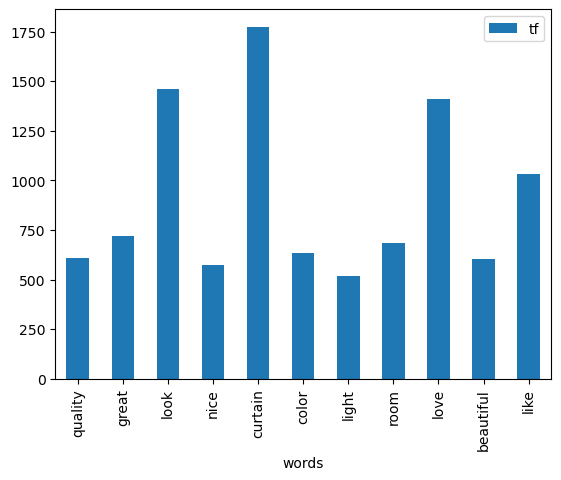

In [7]:
tf = df['Review'].apply(lambda x: pd.value_counts(x.split(' '))).sum(axis=0).reset_index()
tf.columns = ['words', 'tf']
tf[tf['tf'] > 500].plot.bar(x='words', y='tf')
plt.show()

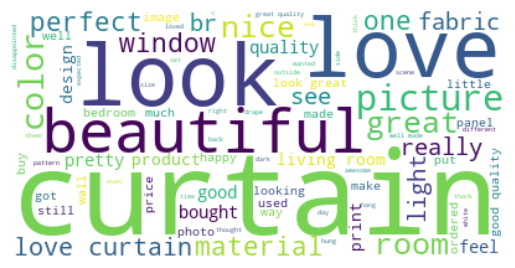

In [8]:
text = ' '.join(i for i in df['Review'])
wordcloud = WordCloud(max_font_size=500, max_words=80, background_color='white').generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
sa = SentimentIntensityAnalyzer()

df['Review'][:10].apply(lambda x: sa.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.537, 'pos': 0.463, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp...
7    {'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [10]:
df['Review'][:10].apply(lambda x: sa.polarity_scores(x)['compound'])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.93
8   0.00
9   0.71
Name: Review, dtype: float64

In [11]:
df['Review'][:10].apply(lambda x: 'pos' if sa.polarity_scores(x)['compound'] > 0 else 'neg')

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [12]:
df['sentiment_label'] = df['Review'].apply(lambda x: 'pos' if sa.polarity_scores(x)['compound'] > 0 else 'neg')

df.columns = [col.lower() for col in df.columns]

In [13]:
df.head()

,star,helpful,title,review,sentiment_label
0,5,0,looks great,happy,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel mis-matched.,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windows.<br />imagery bit ...,pos
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,neg
4,5,0,Wow great purchase,great bang buck can't believe quality material...,pos


In [14]:
df.groupby('sentiment_label')['star'].mean()

sentiment_label
neg   3.45
pos   4.57
Name: star, dtype: float64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment_label'], random_state=143)

tf_idf_word_vectorizer = TfidfVectorizer().fit(X_train)

X_train_tf_idf_word = tf_idf_word_vectorizer.transform(X_train)
X_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test)

In [16]:
log_model = LogisticRegression().fit(X_train_tf_idf_word, y_train)

In [17]:
log_model.score(X_test_tf_idf_word, y_test)

0.8838203848895224